In [1]:
print("Settings.py should be e.g. cnn_flows_prtrain")
#DESIGN PARAMETERS FOR NEURAL NETWORK

VALIDATION_SPLIT = 0.5 #indicated ratio of training to validation data: 0.2 -> 20% VALIDATION data
RANDOMIZED_SEED = 20
SHUFFLE_DATASET = False

TRAINING_PREPARATION = False

BATCH_SIZE = 1
TIME_STEPS = 40

SLICE_FROM_TIME_STEP = 0 #slices from timestep SLICE_FROM_TIMESTEP to the last one

NR_EPOCHS = 200

LR = 0.0001
print("Hyperparameters defined")
print("Bug with learning rate when sequence length is not the same for each element of the dataset")

Settings.py should be e.g. cnn_flows_prtrain
Hyperparameters defined
Bug with learning rate when sequence length is not the same for each element of the dataset


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import time
import os
import os.path as path
import copy

from gait_analysis import AnnotationsCasia as Annotations
from gait_analysis import CasiaDataset
from gait_analysis.Config import Config
from gait_analysis import Composer
from gait_analysis import WeightWatcher
from gait_analysis import AccuracyTrackerTrainTest

import matplotlib.pyplot as plt

from gait_analysis.Models import PretrainConvFlow
from gait_analysis.Models.TransferConvLSTMFlow import TransferConvLSTMFlow

print("done")
%matplotlib inline

done


In [3]:
import gait_analysis.settings as settings

In [4]:
settings.configuration = 'cnn_flows_pretrain'


In [5]:
cc = Config()

loading configuration  cnn_flows_pretrain
[OK]


In [6]:
cc.config['scenes']['load']=True
cc.config['dataset_output']['data']=['flows','scenes']
cc.config['transformers']['DimensionResize'] =  {'start': 5, 'dimension': 40, 'target': ["scenes","flows","annotations"],'annotations_offset': 1}


In [7]:
composer = Composer()
transformer = composer.compose()
dataset = CasiaDataset(transform=transformer)
dataset_size = len(dataset)
indices = list(range(dataset_size))
print("Dataset size:", len(dataset))
print("Indices size:", len(indices))
split = int(np.floor(VALIDATION_SPLIT * dataset_size))
print("Split:", split)
if SHUFFLE_DATASET:
    np.random.seed(RANDOMIZED_SEED)
    indices = np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]
train_sampler = torch.utils.data.SequentialSampler(train_indices)
test_sampler = torch.utils.data.SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, sampler=test_sampler)

Dataset size: 1655
Indices size: 1655
Split: 827


In [8]:
dataset[0][0].keys()

dict_keys(['flows', 'scenes'])

In [9]:
# net_test = net.eval()
net_test = TransferConvLSTMFlow()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net_test.load_state_dict(torch.load('/home/ron/PycharmProjects/Gait2019/gait_project/saved_models/TransferConvLSTMFlow/TransferConvLSTMFlowB16.pth'))
net_test.to(device)
net_test.eval()

TODO: doesn't x = x.view(BATCH_SIZE,TIME_STEPS*LSTM_HIDDEN_FEATURES) mix up batch size order?
TODO: BATCH_SIZE is currently fixed and one
TODO: Is x_arr in device?


TransferConvLSTMFlow(
  (conv_net): PretrainConvFlow(
    (features): Sequential(
      (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
      (10): ReLU()
      (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (12): Conv2d(16, 6, kernel_size=(3, 3), stride=(1, 1))
      (13): ReLU()
      (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (classifier): Sequential(
      (0): Linear(in_features=90, out_features=120, bias

In [10]:
with torch.no_grad():
    inputs, labels = next((iter(test_loader)))
    data_in = [s.to(device) for s in inputs['flows']]
    labels = labels
    labels = labels.detach().cpu().numpy()[0]
    preds = net_test(data_in)
    preds = preds.detach().cpu().numpy()
    print(preds.shape)
    preds = np.argmax(preds, axis=2).astype(float)[0]
    print(preds)
    print(labels)


(1, 40, 3)
[1. 1. 1. 1. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0. 0.]


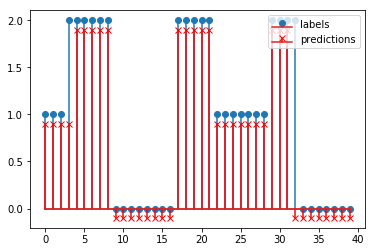

In [11]:
plt.stem(labels)
plt.stem(preds-0.1,linefmt='r-',markerfmt='rx')
plt.legend({'labels','predictions'},loc=1)


In [ ]:
# finding error to plot
cases = []
cnt=0
ii = 0
error_cnt = 0
img_cnt = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        per_seq = dataset.dataset_items[test_indices[ii]]
        ii+=1
        data_in = [s.to(device) for s in inputs['flows']]
        scenes = inputs['scenes']
        # labels = labelslabel_element
        labels = labels.detach().cpu().numpy()[0]
        preds = net_test(data_in)
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=2).astype(float)[0]
        a = preds==labels
        error_cnt += a.sum()
        img_cnt += len(labels) 
        if not sum(preds-labels)==0:
            preds_wrong=preds
            labels_wrong = labels
            scenes_wrong = scenes
            per_seq_wrong = per_seq
            cases.append((preds_wrong, labels_wrong, scenes_wrong, per_seq_wrong))
            cnt +=1 
        #    if cnt==100:
        #        break
print('error count',img_cnt-error_cnt,'imcount', img_cnt)

Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file
Patch: repeat last image on missing flow file


In [20]:
100*(5040-4730)/5040

6.150793650793651

/home/ron/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


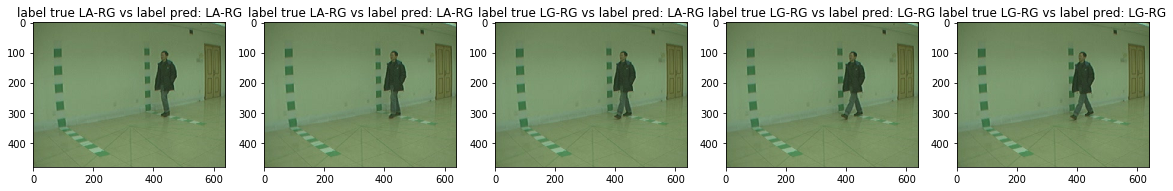

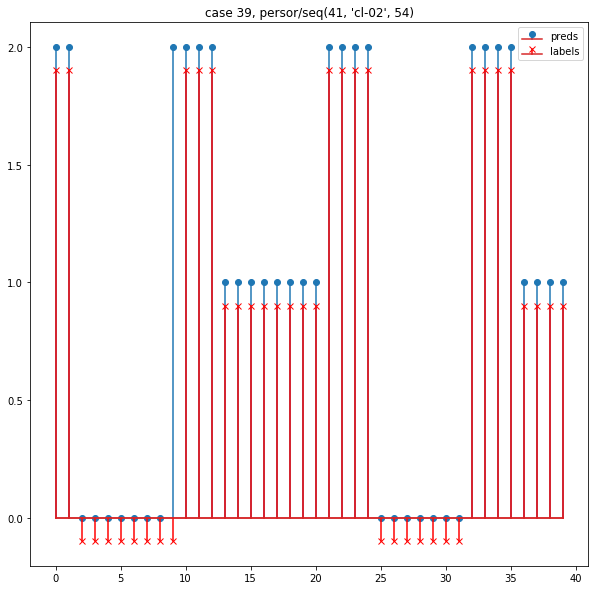

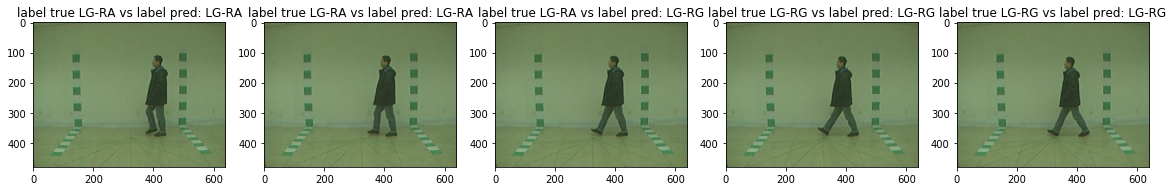

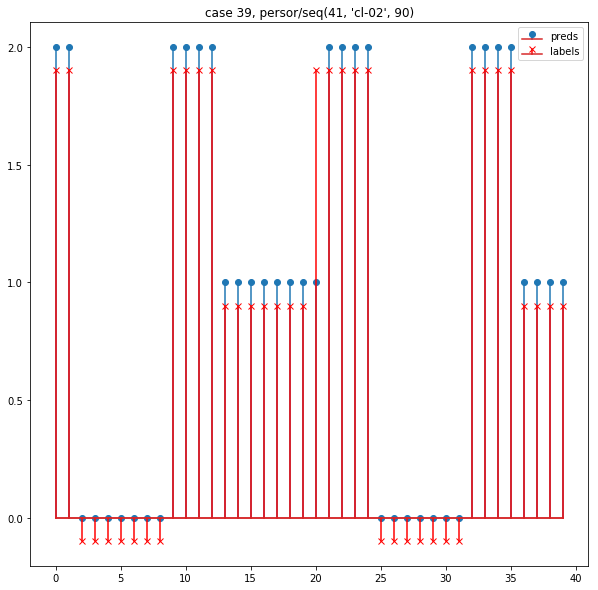

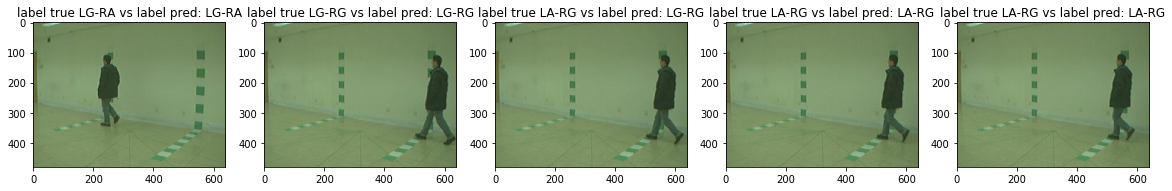

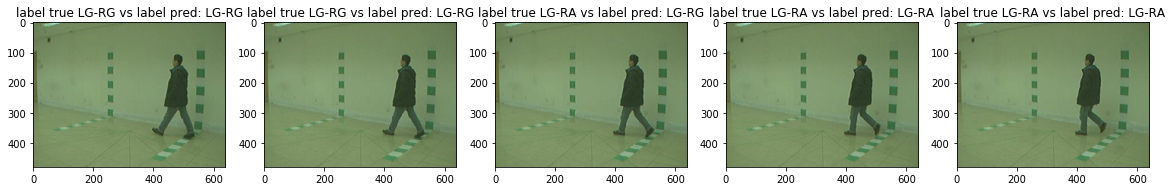

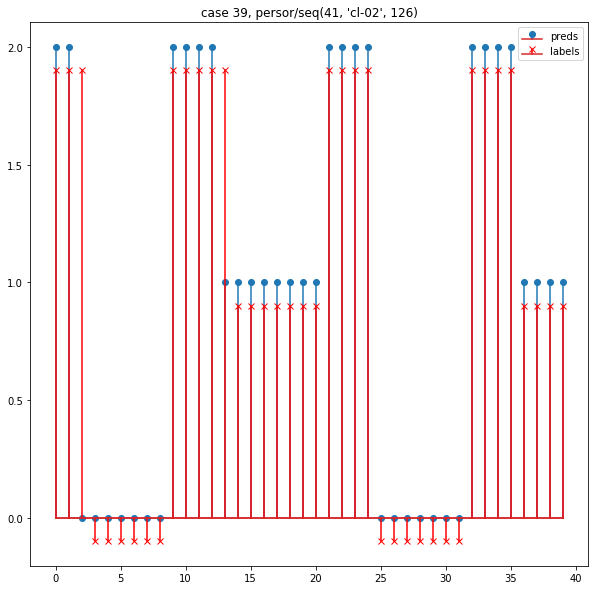

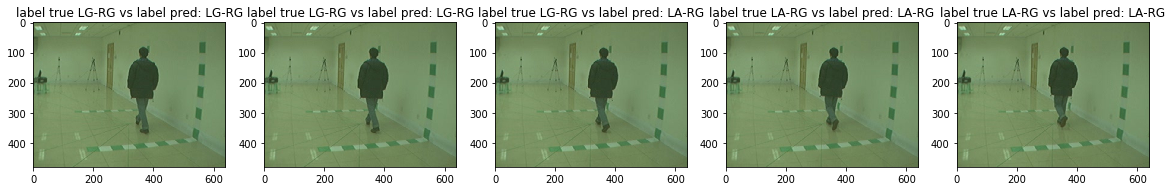

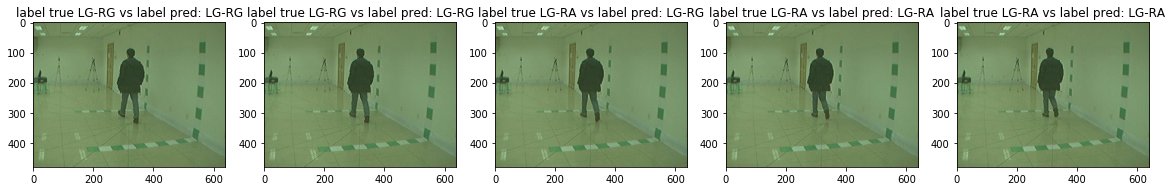

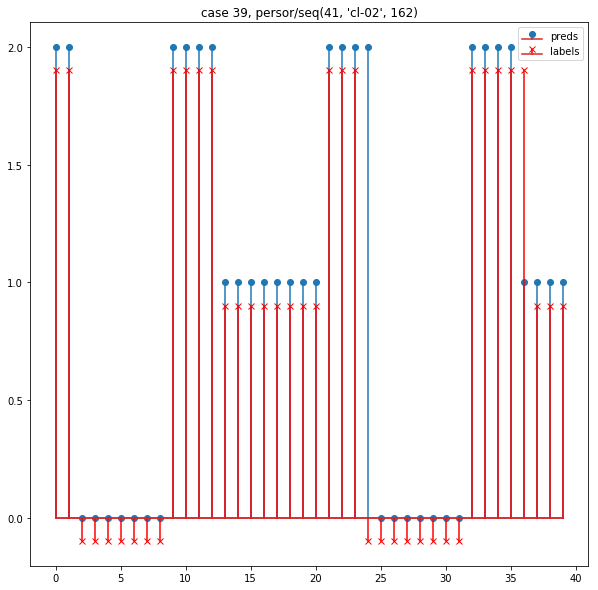

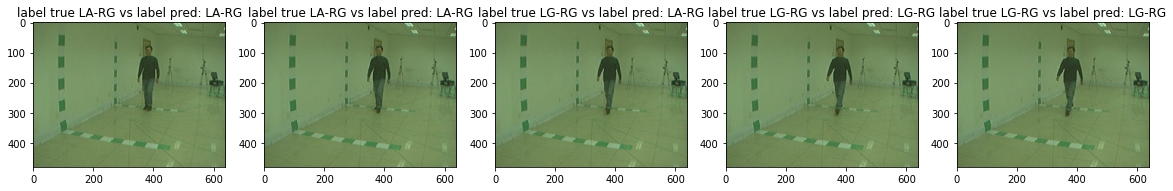

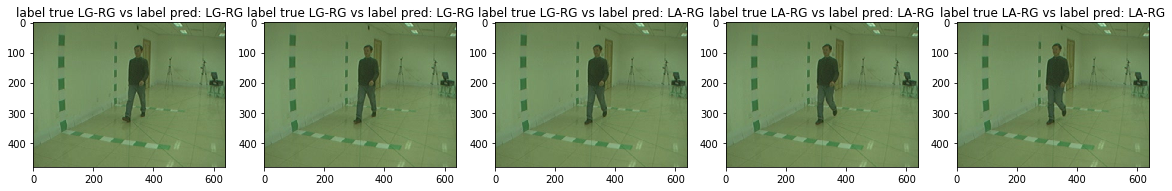

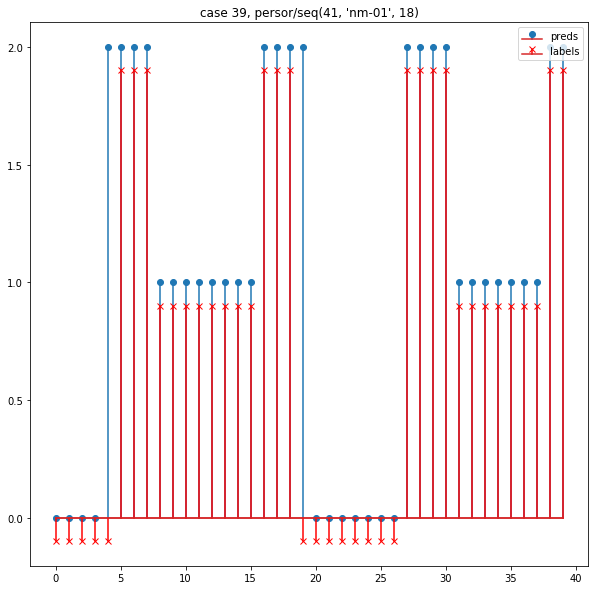

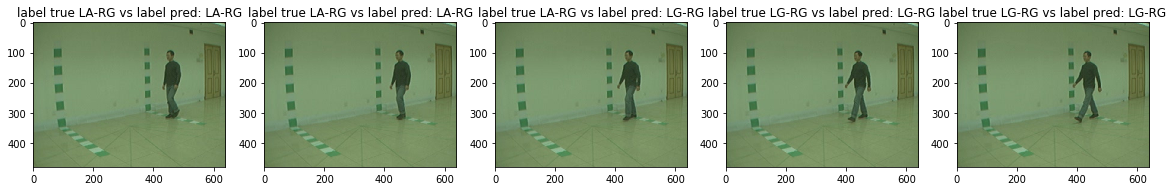

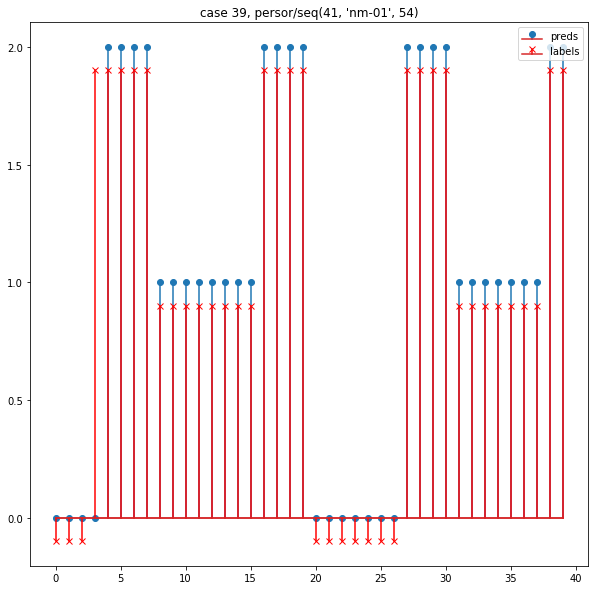

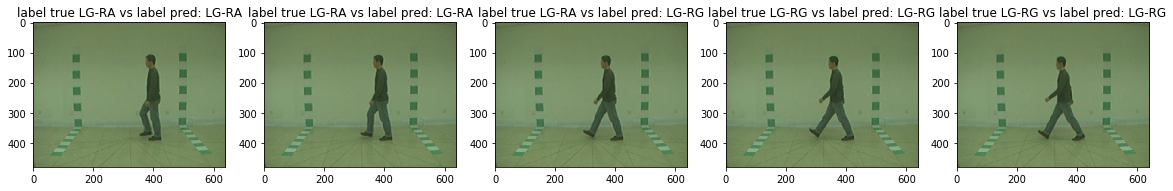

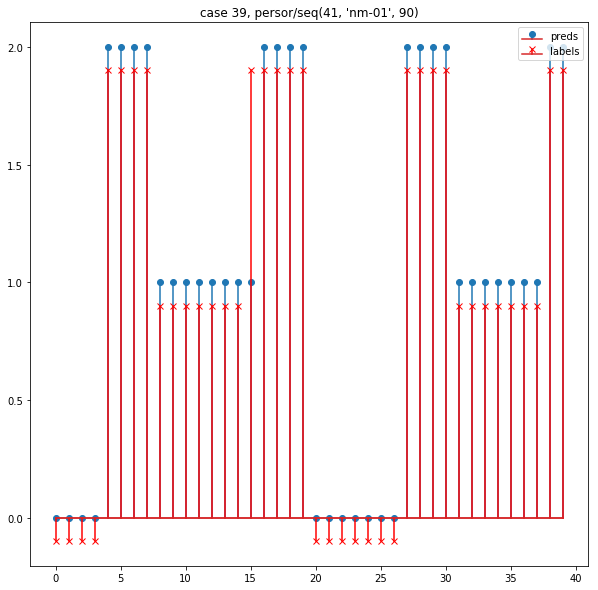

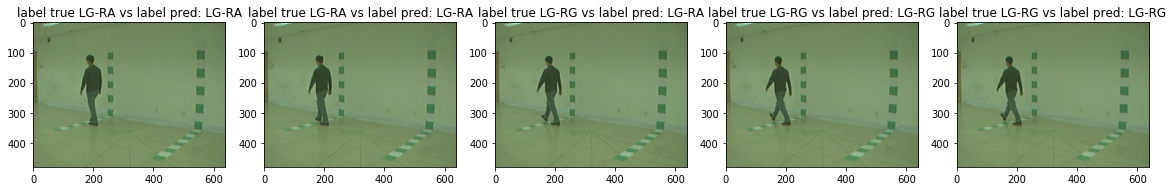

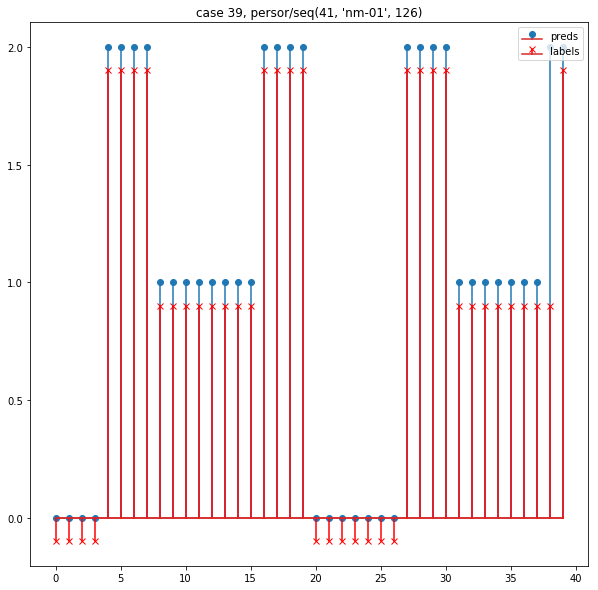

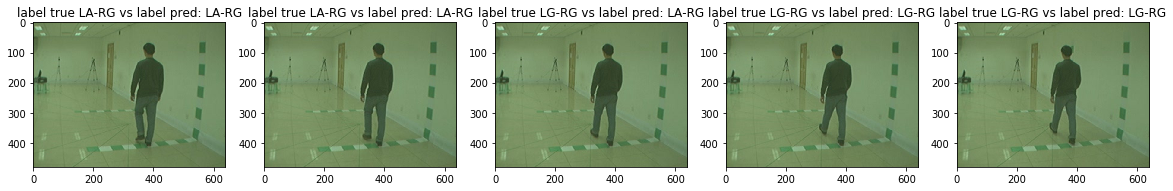

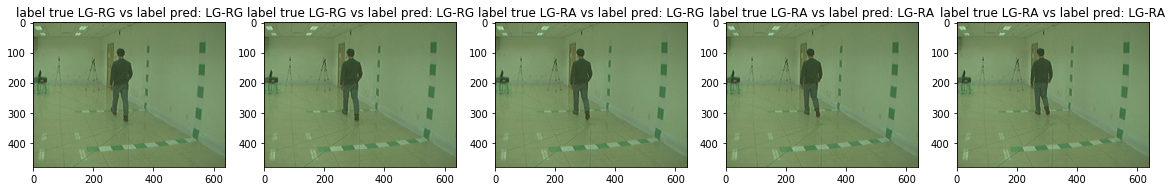

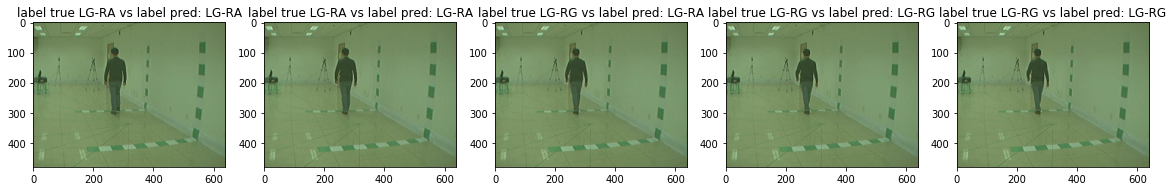

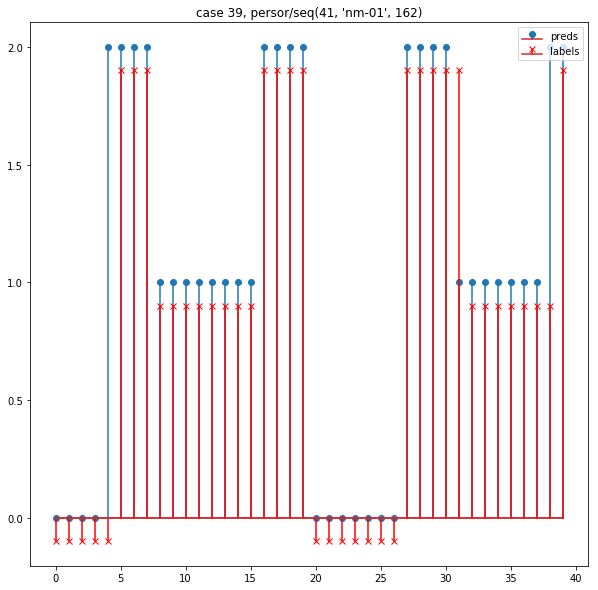

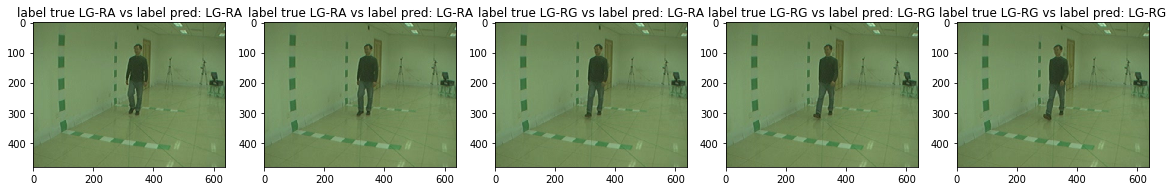

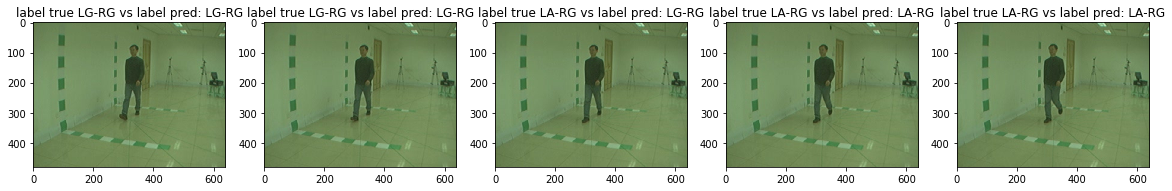

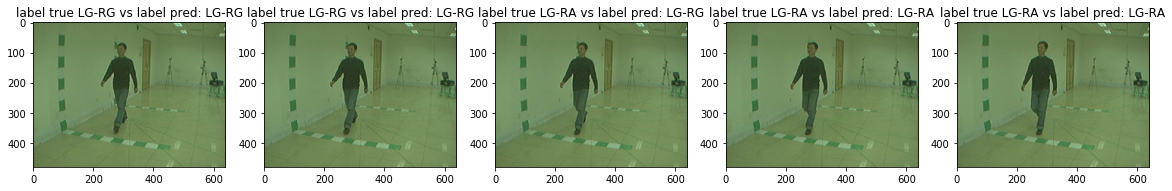

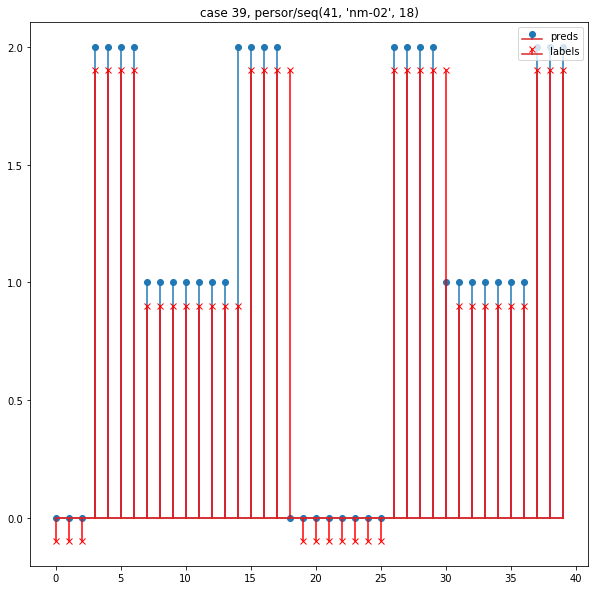

In [16]:
labels_opts = {0:"LA-RG",1:"LG-RA",2:'LG-RG'}
PLOT_ALL = False
for i, case in enumerate(cases[40:50]):
    preds_wrong, labels_wrong, scenes_wrong, per_seq_wrong  = case[0], case[1], case[2], case[3]
    
    for i in range(len(preds_wrong)):
        if PLOT_ALL:
            plt.figure(figsize=(10,10))
            plt.imshow(scenes_wrong[i].squeeze().cpu().numpy()) 
            if preds_wrong[i]==labels_wrong[i]:
                plt.title('label true {} vs label pred: {}, sequence: {}'.format(labels_opts[labels_wrong[i]],
                                                              labels_opts[preds_wrong[i]],per_seq_wrong))
            else:
                plt.title('ERROR: label true {} vs label pred: {}, sequence: {}'.format(labels_opts[labels_wrong[i]],
                                                          labels_opts[preds_wrong[i]], per_seq_wrong))
        else:      
            if preds_wrong[i] == labels_wrong[i]:
                continue

            black_square = np.zeros_like(scenes_wrong[i].squeeze().cpu().numpy())
            index_after = i+1 if i+1<len(preds_wrong) else -1
            index_before = i-1 if i-1>0 else -1
            index_after_more = i+2 if i+2<len(preds_wrong) else -1
            index_before_more = i-2 if i-2>0 else -1
            plt.figure(figsize=(20,20))
            plt.subplot(1,5,2)
            if index_before>0:
                plt.imshow(scenes_wrong[index_before].squeeze().cpu().numpy()) 
            else:
                plt.imshow(black_square)
            plt.title('label true {} vs label pred: {}'.format(labels_opts[labels_wrong[index_before]],
                                                              labels_opts[preds_wrong[index_before]]))
            plt.subplot(1,5,3)
            plt.imshow(scenes_wrong[i].squeeze().cpu().numpy())
            plt.title('label true {} vs label pred: {}'.format(labels_opts[labels_wrong[i]],
                                                              labels_opts[preds_wrong[i]]))
            plt.subplot(1,5,4)
            if index_after>0:
                plt.imshow(scenes_wrong[index_after].squeeze().cpu().numpy()) 
            else:
                plt.imshow(black_square)
            plt.title('label true {} vs label pred: {}'.format(labels_opts[labels_wrong[index_after]],
                                                              labels_opts[preds_wrong[index_after]]))
            plt.subplot(1,5,5)
            if index_after_more>0:
                plt.imshow(scenes_wrong[index_after_more].squeeze().cpu().numpy()) 
            else:
                plt.imshow(black_square)            
            plt.title('label true {} vs label pred: {}'.format(labels_opts[labels_wrong[index_after_more]],
                                                              labels_opts[preds_wrong[index_after_more]]))
            plt.subplot(1,5,1)
            if index_before_more>0:
                plt.imshow(scenes_wrong[index_before_more].squeeze().cpu().numpy()) 
            else:
                plt.imshow(black_square)
            plt.title('label true {} vs label pred: {}'.format(labels_opts[labels_wrong[index_before_more]],
                                                              labels_opts[preds_wrong[index_before_more]]))
    plt.figure(figsize=(10,10))
    plt.stem(labels_wrong)
    plt.stem(preds_wrong-0.1,linefmt='r-',markerfmt='rx')
    plt.legend({'preds','labels'},loc=1)
    plt.title('case {}, persor/seq{}'.format(i,per_seq_wrong))

In [14]:
scenes_wrong[0].squeeze().cpu().numpy().shape

(480, 640, 3)

In [15]:
plt.close()